In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# plt.style.use('ggplot')
import seaborn as sns
from enum import Enum
import matplotlib.colors as mcolors
import colorsys
import os

In [28]:
# results = pd.read_csv("../test_results/hyper_sdqlpy_dense_tuning_test_results.csv") 
results = pd.read_csv("../test_results/hyper_sdqlpy_pandas_tpch_direct_optimisations_test_results.csv") 
results = results[results['Query Name'] == "Pandas Converted (Hyper DB)"]

In [29]:
duck_results = pd.read_csv("../test_results/duck_pandas_uplan.csv") 

In [30]:
results = pd.concat([results, duck_results], ignore_index=True)

In [31]:
print(f"Overall Results: {len(results)}")

# Filter for Correct == True and Executed == Yes
results = results[(results.Correct == True) & (results.Executed == "Yes")]
print(f"Correct Results: {len(results)}")

Overall Results: 26
Correct Results: 26


In [32]:
def g_mean(x):
    a = np.log(x)
    return np.exp(a.mean())

def pre_process(df):
    # Sort Query Name column to in-order
    def extract_number(name):
        if isinstance(name, int):
            return name
        else:
            return int(name.split(" ")[1])

    df['Query Number'] = df.apply(lambda row : extract_number(row['Query Number']), axis = 1)
    df = df.sort_values(['Query Number'])

    # Fix the runs column
    def fix_runs(runs):
        new_runs = list(str(str(runs)[1:-1]).split(","))
        for i in range(0, len(new_runs)):
            new_runs[i] = float(new_runs[i].strip())
        return new_runs

    df['Runs'] = df.apply(lambda row : fix_runs(row['Runs']), axis = 1)

    def ignore_first_gmean(runs):
        return g_mean(runs[1:])
    
    def ignore_first_mean(runs):
        return sum(runs[1:]) / len(runs[1:])

    df["Mean"] = df.apply(lambda row : ignore_first_mean(row['Runs']), axis = 1)
    df["Query Type"] = df["Query Name"]
    df = df[["Query Type", "Query Number", "Mean", "Runs"]]
    
    return df

results = pre_process(results)

In [33]:
def make_compare_graph(df, order, color, filename):
    # plot with seaborn barplot
    sns.set(rc={'figure.figsize':(10,6)})
    background_color = '#f1f4f5'
    sns.set(rc={'axes.facecolor':background_color})
    plt.rcParams['patch.linewidth'] = 0.3
    plt.rcParams['patch.edgecolor'] = 'k'

    ax = sns.barplot(data=df, x='Query Number', y='Mean', hue='Query Type',
                     palette=color, hue_order=order)

    ax.set_yscale("log")
    ax.set(xlabel='Queries', ylabel='Mean Runtime (s)')

    # the non-logarithmic labels 
    ticks = [0.1, 1, 10]
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticks)

    #set parameters for tick labels
    plt.tick_params(axis='x', which='major', labelsize=10)
    plt.tick_params(axis='y', which='major', direction="out", colors="k", left=True)

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10),
              ncol=4, fancybox=True, shadow=True)

    if filename != None:
        plt.savefig(filename, bbox_inches="tight")
    plt.show()

In [34]:
results

,Query Type,Query Number,Mean,Runs
0,Pandas Converted (Hyper DB),1,1.394687,"[1.4598917961120605, 1.3943626880645752, 1.396..."
1,Pandas Converted (Hyper DB),2,0.306689,"[0.3098127841949463, 0.310016393661499, 0.3045..."
2,Pandas Converted (Hyper DB),3,0.573970,"[0.6149234771728516, 0.5762436389923096, 0.572..."
22,Pandas Converted (Duck DB),3,0.550335,"[0.5905005931854248, 0.547274112701416, 0.5605..."
3,Pandas Converted (Hyper DB),4,0.195155,"[0.19483351707458496, 0.1954329013824463, 0.20..."
4,Pandas Converted (Hyper DB),5,0.381002,"[0.37644267082214355, 0.37877702713012695, 0.3..."
5,Pandas Converted (Hyper DB),6,0.083873,"[0.08753085136413574, 0.08356738090515137, 0.0..."
23,Pandas Converted (Duck DB),6,0.152934,"[0.16807270050048828, 0.18213820457458496, 0.1..."
6,Pandas Converted (Hyper DB),7,0.504345,"[0.5046780109405518, 0.5032501220703125, 0.503..."
7,Pandas Converted (Hyper DB),8,0.372092,"[0.37009239196777344, 0.37357306480407715, 0.3..."


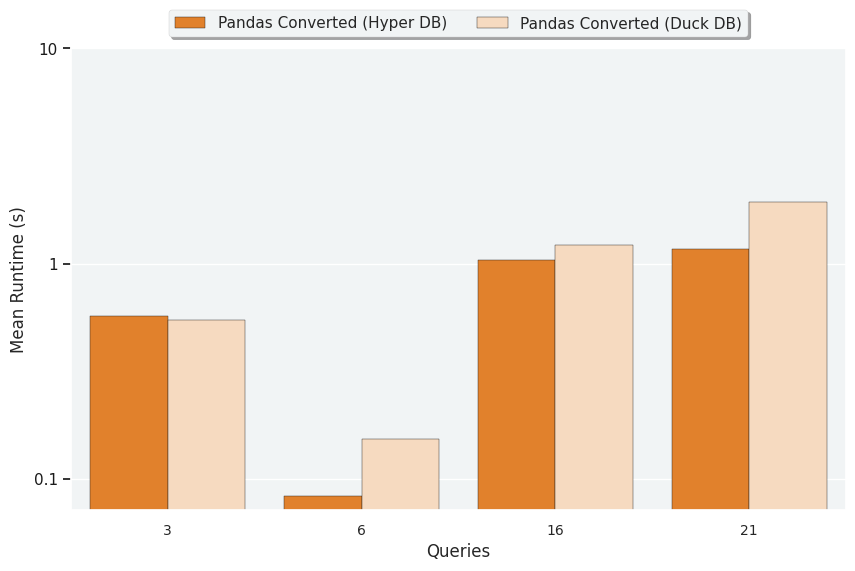

In [35]:
current_df = results[results["Query Number"].isin([3, 6, 16, 21])]
pg_order = ["Pandas Converted (Hyper DB)", "Pandas Converted (Duck DB)"]
pg_color = ['tab:orange','#ffd9b7']
pg_filename = None

make_compare_graph(current_df, pg_order, pg_color, pg_filename)
